# A NOTEBOOK FOR COMPELTE TIME SERIES ANALYSIS

## UNIVARIATE TIME SERIES

### What is a univariate time series?

A univariate time series, as the name suggests, is a series with a single time-dependent variable.

For example DOD sales of XXXX (XXXX)

If we are asked to predict the sales for the next few days, we will look at the past values and try to gauge and extract a pattern. We would notice that the orders are comparatively lower in on week days compared to weekends. Also if you have data for the past years, you would observe that the absolute numbers of orders are also increasing. Orders also follow a general increasing trend. 

### But what makes a TS different from a regular regression problem?

#### 1. It is time dependent: 
So the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case.
#### 2. Seasonality in time series data:
Along with an increasing or decreasing trend, most TS have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, if you see the sales of a woolen jacket over time, you will invariably find higher sales in winter seasons.

## Importing All the Required Libraries

In [2]:

import os
from statsmodels.tsa.seasonal import seasonal_decompose
import re
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
from textblob import TextBlob
# import snowflake.connector
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import requests
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import snowflake.connector
import sqlalchemy
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL
import requests

%matplotlib inline

## Importing the Time Series Dataset 

In [18]:
df = pd.read_csv('Data For AFT.csv')

In [19]:
df.DT = pd.to_datetime(df.DT, format = '%m/%d/%Y')

In [20]:
grouped = df.groupby(['DT', 'XXXX'], as_index = False)
Data_agg = grouped['XXXX'].agg(np.sum)

In [1]:
Data_agg

NameError: name 'Data_agg' is not defined

## Convertng the Data into Time Series Object

Here we are creating an time series object which will be further used in the process. Following Changes are done to get a timeseries object:
1. Changed the data type of date column (DT) from string to datetime[64]
2. Filtered just the order and date column 
3. Replaced the default index with DT column

In [22]:
#Data_High_Conf.DT = pd.to_datetime(Data_High_Conf.DT, format = '%m/%d/%Y')

In [2]:
TS = Data_agg[['DT', 'XXXX']]
TS.set_index('DT', inplace = True)
TS = TS.sort_index()
TS

NameError: name 'Data_agg' is not defined

### Finding out seasonality and trend in the data using trend decompose

C:\Users\anup.singh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.
C:\Users\anup.singh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


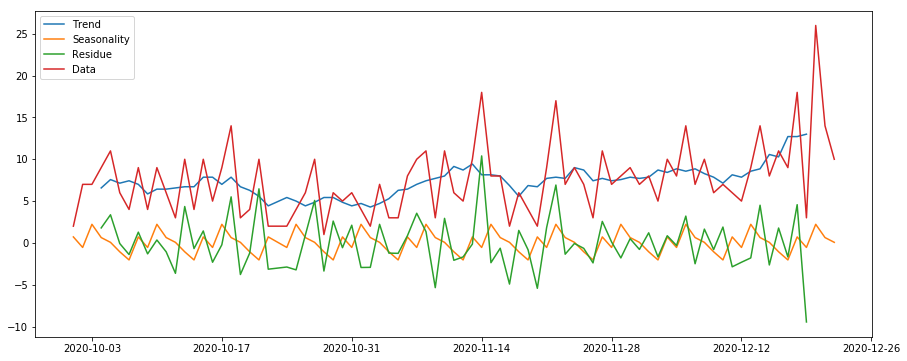

In [27]:
decompose1 = seasonal_decompose(Data_agg.ITEM_QTY, freq = 7)
decompose2 = seasonal_decompose(decompose1.seasonal, freq = 7 )
fig = plt.figure(figsize = (15,6))
trace_1 = plt.plot(Data_agg.DT , decompose1.trend, linestyle='solid', label='Trend')
trace_2 = plt.plot(Data_agg.DT , decompose1.seasonal, linestyle='solid', label='Seasonality' )
trace_3 = plt.plot(Data_agg.DT , decompose1.resid, linestyle='solid' , label='Residue')
trace_4 = plt.plot(Data_agg.DT , Data_agg.ITEM_QTY, linestyle='solid', label= 'Data')
#trace_5 = plt.plot( df.DT , decompose2.seasonal, linestyle='solid', label= 'Seasonality2')
plt.legend()


In [28]:
ts_log = np.log(TS)

C:\Users\anup.singh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


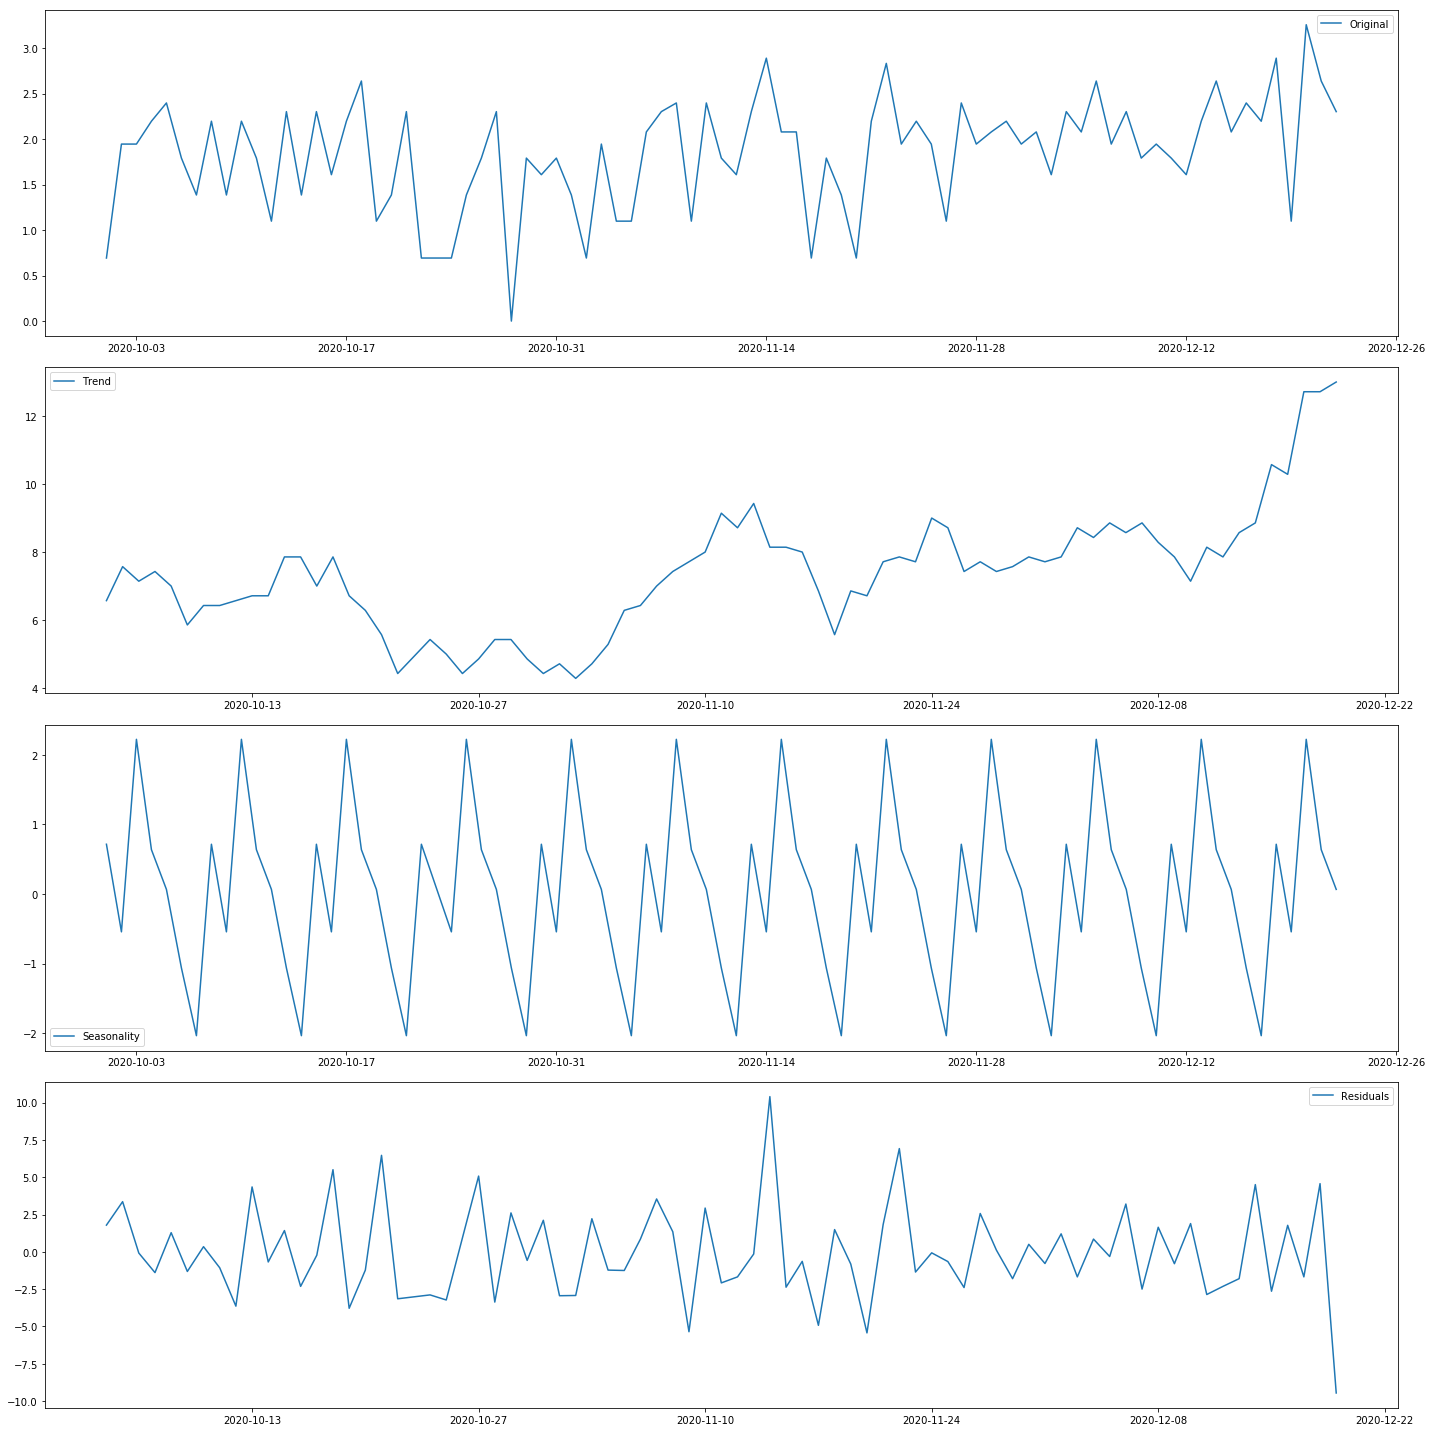

In [29]:
decompose = seasonal_decompose(TS, freq = 7)


fig = plt.figure(figsize = (20,20))

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot( decompose.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Stationarity of a Time Series 

1. Stationary Process: A process that generates a stationary series of observations.
2. Stationary Model: A model that describes a stationary series of observations.
3. Trend Stationary: A time series that does not exhibit a trend.
4. Seasonal Stationary: A time series that does not exhibit seasonality.
5. Strictly Stationary: A mathematical definition of a stationary process, specifically that the joint distribution of observations is invariant to time shift.

## Checking the Stationarity of the time series we are evaluating

The first step will be to check for the stationarity of the time series in context. A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. 

Wy we need a stationary series? 
If a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

1. constant mean
2. constant variance
3. an autocovariance that does not depend on time.

### Defining a function to plot ACF, PCAF, Order trend, and frequency histogram in one single go

In [30]:
def tsplot(y, title, lags=None, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax = ts_ax)
    ts_ax.set_title(title, fontsize=12, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax


### Defining a function to check the stationarity of a time series using Adfuller test 

In [31]:

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize = (15,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    try:
        timeseries = timeseries.iloc[:,0].values
    except:
        timeseries = timeseries
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [3]:
tsplot(TS, 'XXXX')

NameError: name 'tsplot' is not defined

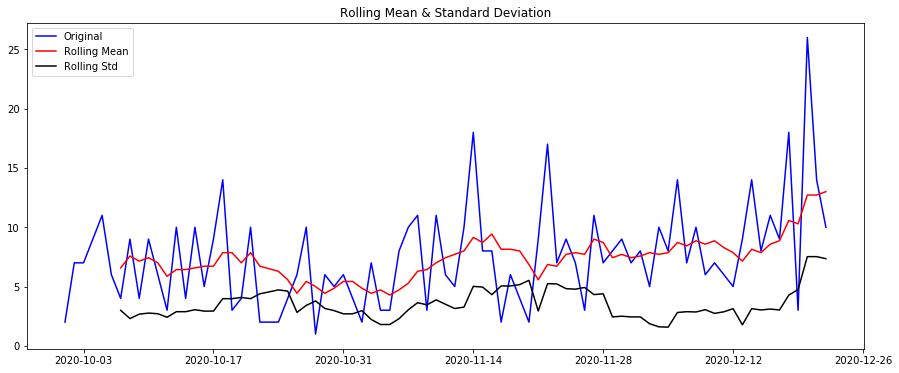

Results of Dickey-Fuller Test:
Test Statistic                 -4.876090
p-value                         0.000039
#Lags Used                      1.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


In [33]:
test_stationarity(TS)

#TS.rolling(7).mean()

### Checking stationarity of the series after log transform 

We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. We are going with log transformation here though:

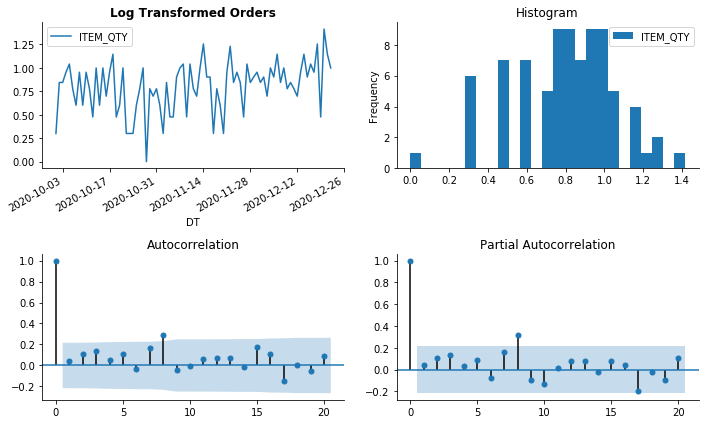

(<matplotlib.axes._subplots.AxesSubplot at 0x24133908308>,
 <matplotlib.axes._subplots.AxesSubplot at 0x241339d4548>)

In [34]:
tsplot(np.log10(TS), 'Log Transformed XXXX')

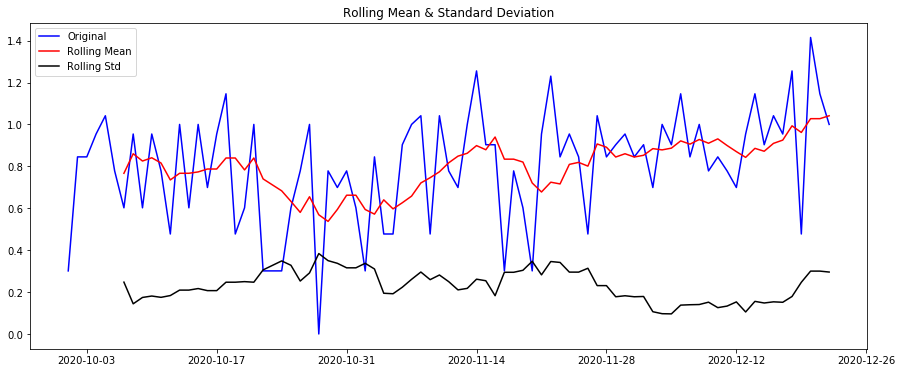

Results of Dickey-Fuller Test:
Test Statistic                 -0.883153
p-value                         0.793470
#Lags Used                      7.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


In [35]:
test_stationarity(np.log10(TS))


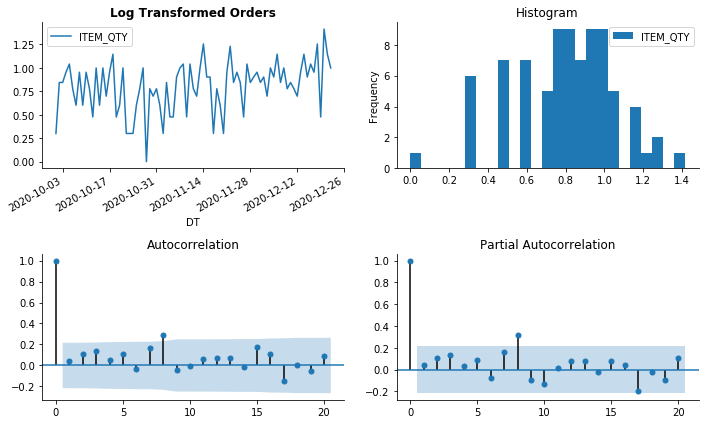

(<matplotlib.axes._subplots.AxesSubplot at 0x24133cb2e48>,
 <matplotlib.axes._subplots.AxesSubplot at 0x24133d3fa88>)

In [36]:
tsplot(np.log10(TS), 'Log Transformed XXXX', lags = 20)

The above results suggest that the log transform series is highly stationary after using a lag of 2 

# ARIMA

C:\Users\anup.singh\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


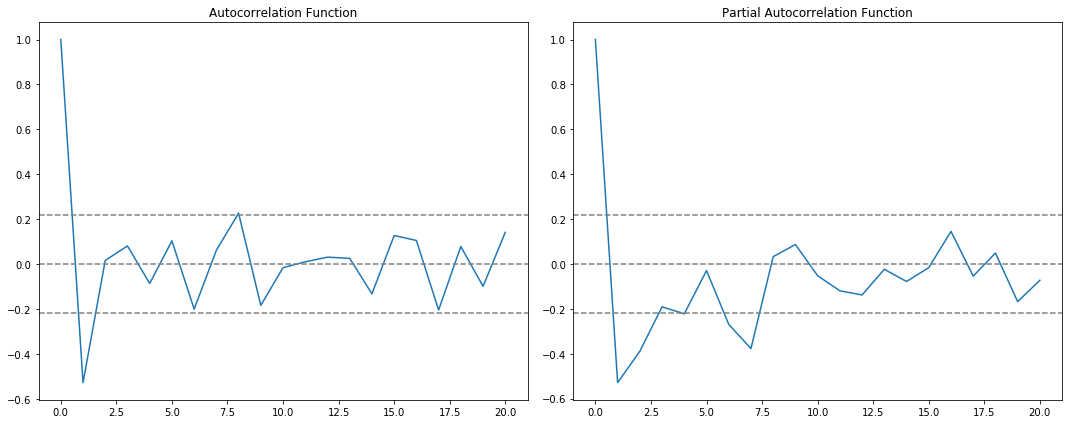

In [37]:
ts_log_diff = ts_log - ts_log.shift(1)
ts_log_diff.dropna(inplace=True)
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

fig = plt.figure(figsize = (15,6))
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## ARIMA

C:\Users\anup.singh\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\anup.singh\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.ITEM_QTY   No. Observations:                   81
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -229.340
Method:                       css-mle   S.D. of innovations              4.050
Date:                Thu, 07 Jan 2021   AIC                            466.680
Time:                        16:27:41   BIC                            476.257
Sample:                             1   HQIC                           470.522
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0646      0.037      1.729      0.084      -0.009       0.138
ar.L1.D.ITEM_QTY    -0.0864      0.161     -0.538      0.591      -0.401       0.229
ma.L1.D.ITEM_QTY    -0.9328 

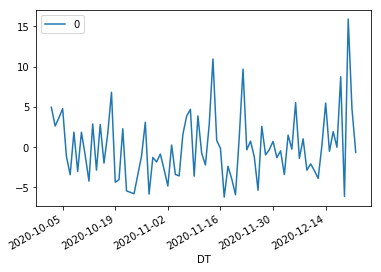

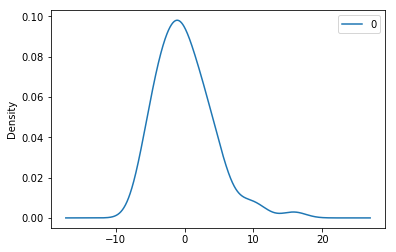

               0
count  81.000000
mean    0.018591
std     4.116054
min    -6.225434
25%    -2.936815
50%    -0.535053
75%     2.270690
max    15.899042


In [64]:
model = ARIMA(TS, order=(1,1,1))  
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

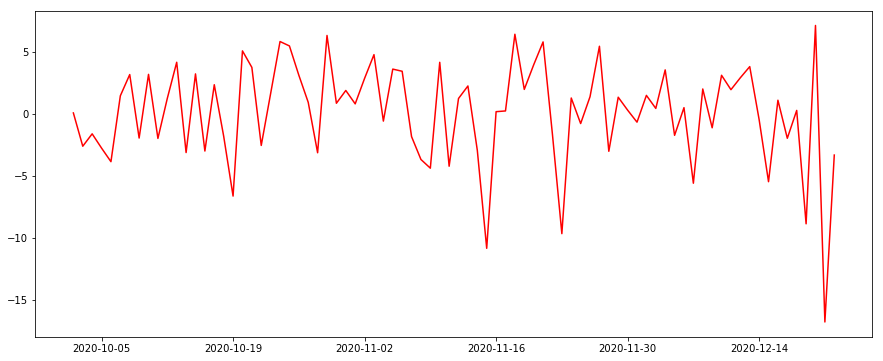

In [57]:
fig = plt.figure(figsize = (15,6))
plt.plot(model_fit.fittedvalues, color='red')

In [34]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## DOD Rolling Predictions using ARIMA

Test MAPE: 21.788
Test MSE: 0.303


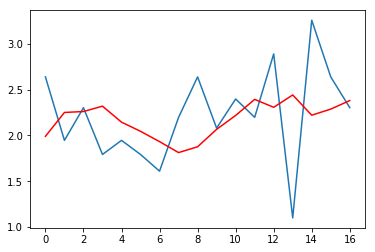

In [71]:
X = ts_log.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(3,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_absolute_percentage_error(test,predictions)
error_2 = mean_squared_error(test, predictions)
#error = mean_absolute_percentage_error(np.exp((test)), np.exp((predictions)))
print('Test MAPE: %.3f' % error)
print('Test MSE: %.3f' % error_2)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

## Steps for ARIMA implementation

The general steps to implement an ARIMA model are –

**Load the data**: The first step for model building is of course to load the dataset
Preprocessing: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.

**Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations

**Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value

**Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model

**Determine the p and q values**: Read the values of p and q from the plots in the previous step

**Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
Predict values on validation set: Predict the future values

**Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set

##############################################################################################################################

## DOD Rolling Predictions using SARIMAX

## What is SARIMA?

ARIMA is one of the most widely used forecasting methods for univariate time series data forecasting. Although the method can handle data with a trend, it does not support time series with a seasonal component.An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMA.

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

**P**: Seasonal autoregressive order.

**D**: Seasonal difference order.

**Q**: Seasonal moving average order.

**m**: The number of time steps for a single seasonal period.

Test MAPE: 23.953
Test MSE: 0.288


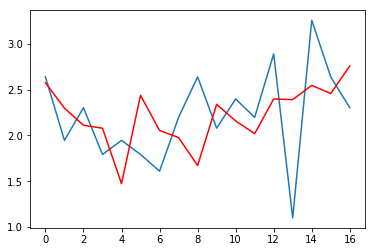

In [78]:
X = ts_log.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = sm.tsa.statespace.SARIMAX(history,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1,0,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_absolute_percentage_error(test,predictions)
error_2 = mean_squared_error(test, predictions)
#error = mean_absolute_percentage_error(np.exp((test)), np.exp((predictions)))
print('Test MAPE: %.3f' % error)
print('Test MSE: %.3f' % error_2)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [1]:
#mod = sm.tsa.statespace.SARIMAX(TS,
#                                order=(2, 1, 2),
#                                seasonal_order=(1, 1, 1, 7),
#                                enforce_stationarity=False,
#                                enforce_invertibility=False)
#results.plot_diagnostics(figsize=(18, 8))
#plt.show()

###############################################################################################################################

## Automating the forecasting proces for all the items

In [5]:
# Reading the query from text file
file = open('XXXX.txt')
query = file.read().replace('\\n', '\n')
query.split(sep = '\n')
file.close()

In [6]:
cursor =  snowflake.connector.connect(
    user='XXXX.XXXX@XXXX.in',
    password='XXXX@XXXX',
    account='XXXX.XXXX-XXXX',
    authenticator='XXXX',
    role='XXXX'    
   ).cursor()


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


In [7]:
cursor.execute(query)
data= cursor.fetchall() 
#creating a list of column names in respective order
columns = ['DT','XXXX','XXXX_ID','XXXX','XXXX']
df2 = pd.DataFrame(data=data, columns=columns)


In [8]:
df2.DT = pd.to_datetime(df2.DT, format = '%Y/%m/%d')
Outlets = (df2.XXXX_ID.unique()).tolist()
SKU =  (df2[ df2.TAGS == 'High Confidence'].SKU.unique()).tolist()
Tags =  (df2.TAGS.unique()).tolist()
Data_agg = df2

## Creating an automated loop for generating forecasts for all the items

Limitation of this piece is: 
1. We cannot tune parameters for item. So we are going with a fixed set of parameters. Obviously the fits will be much better if we tune parameters for very item differently. Until and unless we have an automated way selecting the best hyperparamenter we can't do it

In [10]:
Final_Predictions = pd.DataFrame(columns = ['DT', 'XXXX', 'TEST', 'PREDICTIONS', 'XXXX', 'XXXX','XXXX', 'XXXX', 'XXXX', 'XXXX', 'XXXX', 'XXXX'])

for rest in Outlets:
    for sku in SKU:
        sample = Data_agg[(Data_agg.TAGS == 'High Confidence') & (Data_agg.XXXX == rest ) & (Data_agg.SKU == sku )]
        sample = sample[['DT', 'XXXX']]
        sample.set_index('DT', inplace = True)
        sample.sort_index()
        train_samples = sample.loc['2020-10-02':'2020-12-24']
        test_samples = sample.loc['2020-12-25':'2021-01-08']
        train = train_samples.values
        test = test_samples.values
        history = [x for x in train]
        predictions = list()
        for t in range(len(test)):
            model = sm.tsa.statespace.SARIMAX(history,
                                        order=(1, 1, 1),
                                        seasonal_order=(1,1,1,7),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
            #print('predicted=%f, expected=%f' % (yhat, obs))
        if len(test) > 0:   
            Test_Final = pd.DataFrame(test)
            Predictions_Final = pd.DataFrame(predictions)
            Forecast_Data = pd.concat([Test_Final, Predictions_Final], axis=1)
            Forecast_Data.columns = ['TEST', 'PREDICTIONS']
            test_samples = test_samples.reset_index()
            Forecast_Data = pd.concat([test_samples, Forecast_Data], axis=1)
            Forecast_Data
            Forecast_Data['XXXX'] = XXXX
            Forecast_Data['XXXX'] = XXXX
            Forecast_Data['XXXX'] = Forecast_Data['DT'].dt.week
            Forecast_Data['WEEK_DAY'] = Forecast_Data['DT'].dt.dayofweek
            all_data = sample.reset_index()
            all_data['2_WEEK_MED'] = all_data['XXXX'].rolling(14).median()
            all_data['1_WEEK_MED'] = all_data['XXXX'].rolling(7).median()
            Forecast_Data = pd.merge(Forecast_Data, all_data[['DT','2_WEEK_MED', '1_WEEK_MED']], on = 'DT', how = 'left')
            Forecast_Data['PRED_FINAL'] = np.where( Forecast_Data['2_WEEK_MED'] >=  Forecast_Data['PREDICTIONS'], Forecast_Data['2_WEEK_MED'],  Forecast_Data['PREDICTIONS'])
            Forecast_Data['PRED_FINAL_2'] = np.where( Forecast_Data['1_WEEK_MED'] >=  Forecast_Data['PREDICTIONS'], Forecast_Data['1_WEEK_MED'],  Forecast_Data['PREDICTIONS'])
            Final_Predictions = Final_Predictions.append(Forecast_Data)
        
        

C:\Users\anup.singh\AppData\Local\Continuum\anaconda3\envs\AnupEnv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\anup.singh\AppData\Local\Continuum\anaconda3\envs\AnupEnv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\anup.singh\AppData\Local\Continuum\anaconda3\envs\AnupEnv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\anup.singh\AppData\Local\Continuum\anaconda3\envs\AnupEnv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\anup.singh\AppData\Local\Continuum\anaconda3\envs\AnupEnv\lib\site-packages\sta

In [11]:
Final_Predictions.to_csv('Manual_SARIMA_Univariate_Test_Data - All High Confidence.csv')

## Auto SARIMA Model

To solve the limitation we mentioned above, we are going to use AUTO ARIMA package to find the most suitable model for the respective item

#### But how did the model figure out the best combination of these parameters? 
Auto SARIMA takes into account the AIC and BIC values generated (as you can see in the code) to determine the best combination of parameters. AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) values are estimators to compare models. The lower these values, the better is the model.

In [9]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

In [13]:
df2 = pd.read_csv('XXXX Sales Data XXXX Level - Forecasting.csv')
df2.DT = pd.to_datetime(df2.DT, format = '%m/%d/%Y')
Outlets = (df2.XXXX_ID.unique()).tolist()
SKU =  (df2[ df2.TAGS == 'High Confidence'].XXXX.unique()).tolist()
Tags =  (df2.TAGS.unique()).tolist()
Data_agg = df2

In [38]:
sample = Data_agg[(Data_agg.TAGS == 'High Confidence') & (Data_agg.XXXX_ID == XXXX) & (Data_agg.SKU == "XXXX-XXXX")]
sample = sample[['DT', 'XXXX']]
sample.set_index('DT', inplace = True)
sample = sample.sort_index()

In [15]:
train_samples = sample.loc['2020-10-01':'2020-12-01']
test_samples = sample.loc['2020-12-02':'2020-12-30']

In [17]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(train_samples)

(0.01, False)

In [46]:
arima_model =  auto_arima(train_samples,start_p=0, d=1, start_q=0, 
                          max_p=7, max_d=2, max_q=7, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D= 2,
                          max_Q = 5, m = 7 , seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=364.796, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=340.942, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=346.288, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=339.765, Time=0.08 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=332.545, Time=0.18 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=333.927, Time=0.30 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=0.70 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(4,1,1)[7]             : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=348.780, Time=0.20 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=325.605, Time=0.26 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=329.258, Time=0.11 sec
 ARIMA(2,1,0)(4,1,0)[7]             : AIC=325.407, Time=0.40 sec
 ARIMA(2,1,0)(5,1,0)[7]             : AIC=327.237, Time=0.72 se

In [47]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   61
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 7)   Log Likelihood                -153.585
Date:                            Wed, 13 Jan 2021   AIC                            317.170
Time:                                    13:15:09   BIC                            327.022
Sample:                                         0   HQIC                           320.959
                                             - 61                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9644      0.187     -5.146      0.000      -1.332      -0.597
ar.S.L7       -0.5946      0.161     -3.700      0.000      -0.910      -0.280
ar.S.L14      -0.4370      0.178     -2.457      0.014      -0.786      -0.088
ar.S.L21      -0.4382      0.235     -1.866      0.062      -0.898       0.022
sigma2        15.8382      3.824      4.142      0.000       8.343      23.333
===================================================================================
Ljung-Box (Q):                       50.01   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.13   Prob(JB):                         0.28
Heteroskedasticity (H):               1.21   Skew:                             0.53
Prob(H) (two-sided):                  0.68   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 29),index=test_samples.index)
prediction.columns = ['predicted_sales']


In [51]:
(arima_model.predict(n_periods = 1))[0]

5.763220111167194

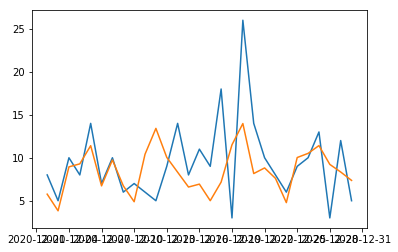

In [49]:
#plt.figure(figsize=(20,15))
#plt.plot(train_samples,label="Training")
plt.plot(test_samples,label="Test")
plt.plot(prediction,label="Predicted")
#plt.legend(loc = 'Left corner')
plt.show()

Test MAPE: 53.484
Test MSE: 24.007


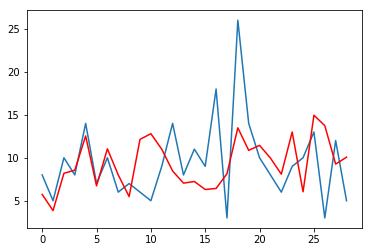

In [56]:
sample = Data_agg[(Data_agg.TAGS == 'High Confidence') & (Data_agg.XXXX_ID == XXXX) & (Data_agg.SKU == "XXXX")]
sample = sample[['DT', 'XXXX']]
sample.set_index('DT', inplace = True)
sample.sort_index()
train_samples = sample.loc['2020-10-01':'2020-12-20']
test_samples = sample.loc['2020-12-21':'2020-12-30']
train = train_samples.values
test = test_samples.values
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = sm.tsa.statespace.SARIMAX(history,
                                order=(0, 1, 1),
                                seasonal_order=(3,1,0,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_absolute_percentage_error(test,predictions)
error_2 = mean_squared_error(test, predictions)
#error = mean_absolute_percentage_error(np.exp((test)), np.exp((predictions)))
print('Test MAPE: %.3f' % error)
print('Test MSE: %.3f' % error_2)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=496.899, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=452.752, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=429.384, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=449.555, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=431.373, Time=0.13 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=431.376, Time=0.21 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=436.403, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=474.344, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=428.675, Time=0.10 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=450.095, Time=0.08 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=430.525, Time=0.24 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=430.559, Time=0.18 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=437.361, Time=0.10 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time

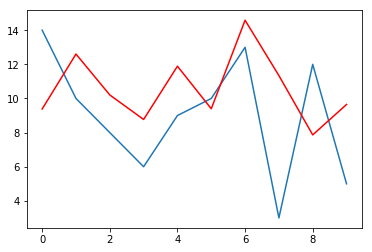

In [59]:
sample = Data_agg[(Data_agg.TAGS == 'High Confidence') & (Data_agg.XXXX_ID == XXXX) & (Data_agg.SKU == "XXXXf")]
sample = sample[['DT', 'XXXX']]
sample.set_index('DT', inplace = True)
sample.sort_index()
train_samples = sample.loc['2020-10-01':'2020-12-20']
test_samples = sample.loc['2020-12-21':'2020-12-30']
train = train_samples.values
test = test_samples.values
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = auto_arima(history,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=2, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D= 2,
                          max_Q = 5, m = 7 , seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )
    #model_fit = model.fit(disp=0)
    output = model.predict(n_period = 1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_absolute_percentage_error(test,predictions)
error_2 = mean_squared_error(test, predictions)
#error = mean_absolute_percentage_error(np.exp((test)), np.exp((predictions)))
print('Test MAPE: %.3f' % error)
print('Test MSE: %.3f' % error_2)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


# APPENDIX

In [ ]:
def aft_sarimax(city,df,y,group_by_var):
    train=df[(df[group_by_var]==city)&(df.index<test_period_start_dt)]
    test=df[(df[group_by_var]==city)&(df.index>=test_period_start_dt)&(df.index<=test_period_end_dt)]
    test_period=len(test)

    model = auto_arima(train[y],
                       exogenous=train[xvar],enforce_invertibility=False,error_action='ignore', suppress_warnings=True, seasonal=True)
    forecast = pd.DataFrame(model.predict(n_periods=len(test),exogenous=test[xvar]),index=test.index)
    forecast.columns=['Predicted_Sarimax']
    result=pd.concat([test[[group_by_var,y]], forecast], axis=1, join='inner')
    #Result_Sarimax=Result_Sarimax.append(result)
    return result